1. 첫번째 실험
   - 데이터증식x
   - clf: ES = acc, CP = val_loss, epoch: 60, batch_size: 40, lr=1e-3
   - 4개 동결 풀음, Es = val_acc, CP = val_loss, lr = 1e-4 (acc최대: 0.48, val_loss최소: 1.36)
   - 2개 동결 풀음, ES: 10번 동안 진전 x시 stop, epoch: 20, lr = 1e-4 (val_acc최대: 0.39, val_loss:1.47~2.4)  
   - 2개 동결 풀음, 위와 동일, lr = 1e-5 (val_acc:0.25~ 0.35, val_loss:1.6~3.4)

2. 두번째 실험
   - 데이터증식x
   - clf= ES: (acc, stop: 10), CP: val_loss, epoch: 50, batch_size: 40, lr=1e-2 (acc: 0.32~ 0.51, loss: 5.7 ~ 1.0, val_acc: 0.18~ 0.42, val_loss: 3.2 ~ 1.0)
   - 4개 동결 풀음, ES = (val_loss, stop: 30), CP = val_loss, epoch: 100, batch_size: 35, lr=1e-3 (acc: 0.45 ~ 0.71, loss: 0.07 ~ 0.34, val_acc: 0.18 ~ 0.42, val_loss: 1.2~2.6)
   - 4개 동결 풀음, ES = (''), CP = '', epoch = '', batch_size = '', lr = 1e-4 (val_acc가 전보다 훨씬 안 좋아짐.)
   
3. 세번째 실험
   - 데이터증식 x
   - clf: 1e-3
   
4. 네번째 실험
   - 데이터 증식
   - batchnormalization

In [1]:
import os
import numpy as np
import keras
from keras.applications import ResNet50V2
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from keras.layers import Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu

# 1. 데이터 전처리
   -  3채널씩 분류
   -  Normalization

In [2]:
base_dir = r'D:\dataset\dental\data'

data = np.load(base_dir + '\\data_Diorco_so_rl.npy')
label = np.load(base_dir + '\\labels_Diorco_so_rl_angle_class.npy')

* 3채널씩 데이터 분류

In [3]:
right = data[:,:,:, 0:3]
left = data[:,:,:, 3:7]

right_label = label[: , 0]
left_label = label[:, 1]

* 3채널로 펼진 데이터(left, right로 나뉜)를 하나의 리스트에 합침

In [4]:
patient_data = []
patient_data.extend(left)
patient_data.extend(right)
patient_data = np.array(patient_data)

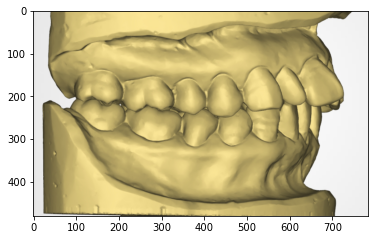

In [5]:
plt.imshow(left[0])

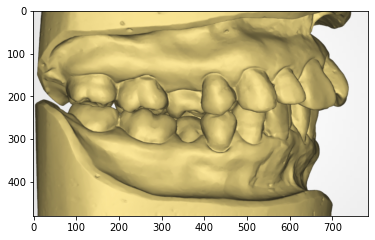

In [6]:
plt.imshow(patient_data[200])

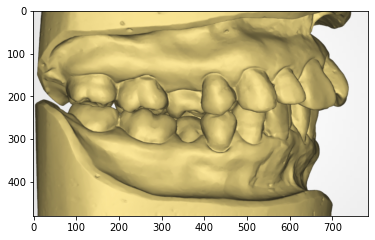

In [7]:
plt.imshow(right[0])

### 라벨데이터(lefft, right로 나뉜)를 하나의 리스트로 합치기

In [5]:
patient_labels = []
patient_labels.extend(left_label)
patient_labels.extend(right_label)
patient_labels = np.array(patient_labels)

In [6]:
train_data, test_data, train_label, test_label= train_test_split(patient_data, patient_labels, test_size = 0.2, random_state = 33, shuffle = True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.2, random_state = 33, shuffle = True)

In [7]:
#원 핫 인코딩을 위해 label을 바꿈
one_hot_train_labels = to_categorical(train_label - 1)
one_hot_validation_labels = to_categorical(val_label  - 1)
one_hot_test_labels = to_categorical(test_label - 1)

### data 증식

In [8]:
datagen = ImageDataGenerator(rotation_range = 10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  fill_mode='nearest'
                                 )

len(train_generator[0][0])

### data normalization
### -1 ~ 1 까지 정규화함

In [9]:
train_data = train_data.astype(np.float32) / 127.5 - 1
test_data = test_data.astype(np.float32) / 127.5 - 1
val_data = val_data.astype(np.float32) / 127.5 - 1

In [10]:
datagen = ImageDataGenerator(zca_whitening=True)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


# 2. callback함수 정의
* callback_clf 학습 시킬 때
   - modelcheckpoint 사용하여 model을 저장
   
        -> monitor = 'acc
        
        -> save_best_only = False
        
        -> period = 1
        
   - Earlystopping 사용하여 acc가 10epoch동안 향상되지 않으면 stop
   
        -> monitor = 'acc'
        
        -> patience = 6
        
        -> mode = max

In [18]:
callbacks_list_clf = [
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience = 19,
        mode = max
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='dental_ResNet50V2_clf_4.h5',
        monitor='val_loss',
        save_best_only=False,
        period = 1
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 10)
]

# 3. model
   -  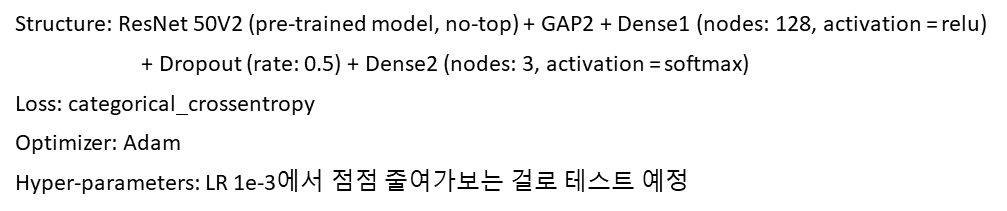

In [12]:
conv_base = ResNet50V2(weights = 'imagenet',
                 include_top = False,
                 input_shape = (480, 784, 3))

In [13]:
#conv_base동결
conv_base.trainable = False

In [14]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 15, 25, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 23,827,971
Trainable params: 262,915
Non-trainable params: 23,565,056
____________________________________

In [15]:
model.compile(optimizer=optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['acc'])

# 4. model 학습

In [19]:
history2 = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 6),
    steps_per_epoch=40,
    epochs = 50,
    callbacks= callbacks_list_clf,
    validation_data=(val_data, one_hot_validation_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
40/40 [==============================] - 19s 481ms/step - loss: 1.2666 - acc: 0.3824 - val_loss: 2.1381 - val_acc: 0.1875
Epoch 2/50
40/40 [==============================] - 13s 335ms/step - loss: 1.3085 - acc: 0.3319 - val_loss: 1.6031 - val_acc: 0.1875
Epoch 3/50
40/40 [==============================] - 14s 342ms/step - loss: 1.1238 - acc: 0.4538 - val_loss: 1.6485 - val_acc: 0.1875
Epoch 4/50
40/40 [==============================] - 15s 363ms/step - loss: 1.0681 - acc: 0.4832 - val_loss: 1.3803 - val_acc: 0.2656
Epoch 5/50
40/40 [==============================] - 14s 347ms/step - loss: 1.0485 - acc: 0.4832 - val_loss: 1.1073 - val_acc: 0.3594
Epoch 6/50
40/40 [==============================] - 14s 346ms/step - loss: 1.0317 - acc: 0.4790 - val_loss: 1.0645 - val_acc: 0.3594
Epoch 7/50
40/40 [==============================] - 14s 340ms/step - loss: 1.0384 - acc: 0.4792 - val_loss: 1.0682 - val_acc: 0.3594
Epoch 8/50
40/40 [==============================] - 14s 342ms/step - 

In [14]:
# Train model
history = model.fit(train_data, one_hot_train_labels,
                    epochs=50,
                    batch_size=40,
                    callbacks = callbacks_list_clf,
                    validation_data=(val_data, one_hot_validation_labels))


Train on 256 samples, validate on 64 samples
Epoch 1/50
256/256 [==============================] - 27s 105ms/step - loss: 1.3602 - acc: 0.3516 - val_loss: 1.1668 - val_acc: 0.1875
Epoch 2/50
256/256 [==============================] - 13s 50ms/step - loss: 1.1354 - acc: 0.3828 - val_loss: 1.0658 - val_acc: 0.3906
Epoch 3/50
256/256 [==============================] - 13s 49ms/step - loss: 1.0554 - acc: 0.4453 - val_loss: 1.1600 - val_acc: 0.2969
Epoch 4/50
256/256 [==============================] - 13s 49ms/step - loss: 1.0592 - acc: 0.4102 - val_loss: 1.1320 - val_acc: 0.2344
Epoch 5/50
256/256 [==============================] - 13s 49ms/step - loss: 1.0320 - acc: 0.4883 - val_loss: 1.1665 - val_acc: 0.2344
Epoch 6/50
256/256 [==============================] - 13s 49ms/step - loss: 1.0515 - acc: 0.4180 - val_loss: 1.1449 - val_acc: 0.3281
Epoch 7/50
256/256 [==============================] - 13s 49ms/step - loss: 1.0104 - acc: 0.5039 - val_loss: 1.1190 - val_acc: 0.3281
Epoch 8/50
256/

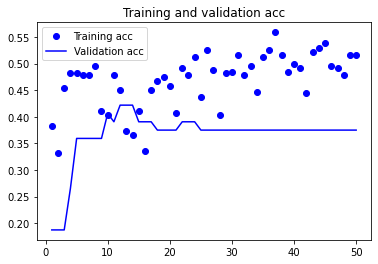

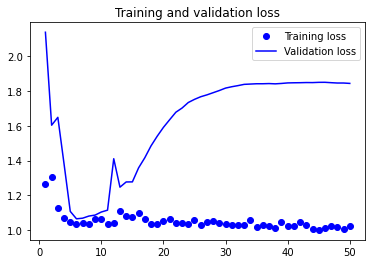

In [20]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
K.clear_session()

In [20]:
del history

# 5. 동결 해제 후 모델 학습 부분
* dental_ResNet_clf.h5 모델 불러와서 conv_base 4개 동결 해제 후 학습

In [11]:
model = models.load_model('dental_ResNet50V2_clf_4.h5')
model.load_weights('dental_ResNet50V2_clf_4.h5')

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [12]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == model.layers[0].layers[186].name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [13]:
len(model.trainable_weights)

10

In [14]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
batch_normalization_1
dense_2

conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


* callback 단계별 동결 해제
   - ModelCheckpoint를 사용하여 val_loss가 향상되지 않으면 model을 저장하지 않음(최상의 모델을 뽑기 위함, model 전체 저장)
   
       -> monitor = 'val_loss'
       -> save_best_only = True
       -> period = 1
       
   - EarlyStopping을 같이 사용하여 val_acc가 15epoch 동안 향상되지 않으면 stop
        
       -> monitor = 'val_acc'
       -> patience = 14
       -> mode = max
       
   - randomstate를 3, 4 번 모델을 만들 때 바꿔주었다 + shuffle = True로 함.(123->13, 13-> 23)

In [15]:
callbacks_list_1 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 24,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='test.h5',
        monitor='val_loss',
        save_best_only=True,
        period = 1
    ),
     keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 10)
]

* lr = 1e-4로 낮춤

In [16]:
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [17]:
history2 = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 6),
    steps_per_epoch=40,
    epochs = 100,
    callbacks= callbacks_list_1,
    validation_data=(val_data, one_hot_validation_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
40/40 [==============================] - 22s 541ms/step - loss: 1.0157 - acc: 0.5672 - val_loss: 1.5183 - val_acc: 0.3750
Epoch 2/100
40/40 [==============================] - 13s 324ms/step - loss: 1.0278 - acc: 0.4958 - val_loss: 1.2145 - val_acc: 0.3906
Epoch 3/100
40/40 [==============================] - 13s 331ms/step - loss: 1.0206 - acc: 0.4750 - val_loss: 1.0638 - val_acc: 0.3906
Epoch 4/100
40/40 [==============================] - 13s 325ms/step - loss: 0.9972 - acc: 0.5424 - val_loss: 1.0719 - val_acc: 0.4219
Epoch 5/100
40/40 [==============================] - 13s 335ms/step - loss: 0.9730 - acc: 0.5875 - val_loss: 1.1102 - val_acc: 0.3281
Epoch 6/100
40/40 [==============================] - 13s 325ms/step - loss: 1.0166 - acc: 0.5210 - val_loss: 1.0686 - val_acc: 0.3906
Epoch 7/100
40/40 [==============================] - 13s 324ms/step - loss: 1.0056 - acc: 0.5546 - val_loss: 1.1573 - val_acc: 0.2656
Epoch 8/100
40/40 [==============================] - 13s 322ms

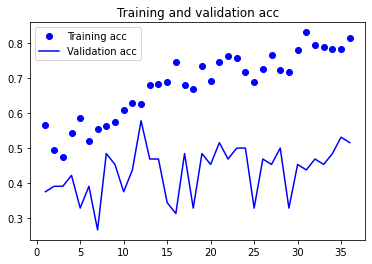

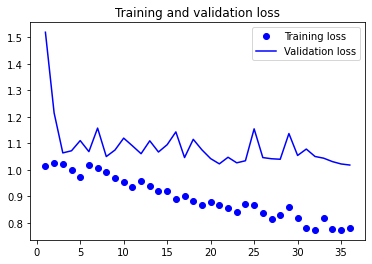

In [18]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
K.clear_session()
del history

In [19]:
del model

In [36]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [11]:
model = models.load_model('test.h5')
model.load_weights('test.h5')

In [12]:
model.layers[0].layers[5].name

'conv2_block1_preact_bn'

* 위 작업 반복 (2개 풂)

In [13]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == model.layers[0].layers[182].name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [14]:
len(model.trainable_weights)

13

In [15]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
batch_normalization_1
dense_2

conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [16]:
callbacks_list_2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 24,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='test_2.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
     keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 5
     )
] 

* lr=1e-5로 했더니 val_acc가 0.468로 지역 최솟값에 갇힘
* 따라서 lr=1e-4로 다시 돌림

In [17]:
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [18]:
history = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 6),
    steps_per_epoch=40,
    epochs = 100,
    callbacks= callbacks_list_2,
    validation_data=(val_data, one_hot_validation_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
40/40 [==============================] - 20s 501ms/step - loss: 0.8127 - acc: 0.7479 - val_loss: 1.2004 - val_acc: 0.3125
Epoch 2/100
40/40 [==============================] - 13s 331ms/step - loss: 0.7844 - acc: 0.7983 - val_loss: 1.3465 - val_acc: 0.2031
Epoch 3/100
40/40 [==============================] - 13s 332ms/step - loss: 0.7754 - acc: 0.8025 - val_loss: 1.2644 - val_acc: 0.2344
Epoch 4/100
40/40 [==============================] - 13s 331ms/step - loss: 0.7782 - acc: 0.7857 - val_loss: 1.4360 - val_acc: 0.2188
Epoch 5/100
40/40 [==============================] - 13s 333ms/step - loss: 0.8058 - acc: 0.7042 - val_loss: 1.4299 - val_acc: 0.2344
Epoch 6/100
40/40 [==============================] - 13s 331ms/step - loss: 0.8173 - acc: 0.7311 - val_loss: 1.4826 - val_acc: 0.2500
Epoch 7/100
40/40 [==============================] - 13s 333ms/step - loss: 0.7975 - acc: 0.7185 - val_loss: 1.2258 - val_acc: 0.2969
Epoch 8/100
40/40 [==============================] - 13s 329ms

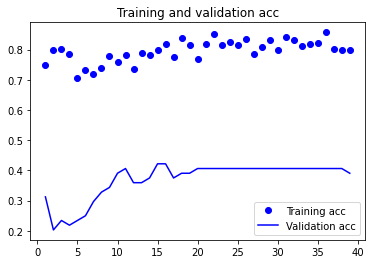

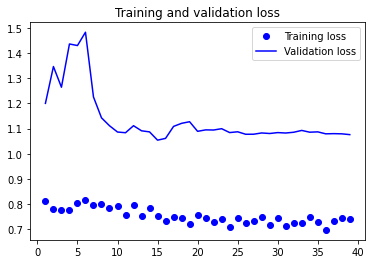

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 3번째(동결 총 12개 풂)

In [17]:
model.layers[0].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 784, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 790, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 240, 392, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 242, 394, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [11]:
model = models.load_model('test_2.h5')
model.load_weights('test_2.h5')

In [12]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == model.layers[0].layers[178].name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [13]:
len(model.trainable_weights)

16

In [14]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
batch_normalization_1
dense_2

conv5_block3_preact_relu
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [15]:
callbacks_list_3 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 24,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='dental_ResNet50V2_3_4.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 5
    )
]

* 1e-6을 하니 지역 최솟값에 갇혀버림(따라서 1e-5로 바꿈)

In [16]:
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [17]:
history = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 6),
    steps_per_epoch=40,
    epochs = 100,
    callbacks= callbacks_list_3,
    validation_data=(val_data, one_hot_validation_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
40/40 [==============================] - 21s 520ms/step - loss: 0.7345 - acc: 0.8151 - val_loss: 1.0364 - val_acc: 0.4531
Epoch 2/100
40/40 [==============================] - 14s 340ms/step - loss: 0.7262 - acc: 0.8208 - val_loss: 1.0142 - val_acc: 0.4844
Epoch 3/100
40/40 [==============================] - 13s 336ms/step - loss: 0.7395 - acc: 0.8178 - val_loss: 1.0125 - val_acc: 0.5156
Epoch 4/100
40/40 [==============================] - 14s 340ms/step - loss: 0.7457 - acc: 0.8167 - val_loss: 0.9953 - val_acc: 0.5156
Epoch 5/100
40/40 [==============================] - 13s 336ms/step - loss: 0.7577 - acc: 0.8008 - val_loss: 0.9860 - val_acc: 0.5156
Epoch 6/100
40/40 [==============================] - 14s 338ms/step - loss: 0.7306 - acc: 0.8361 - val_loss: 0.9699 - val_acc: 0.5312
Epoch 7/100
40/40 [==============================] - 14s 340ms/step - loss: 0.7141 - acc: 0.8292 - val_loss: 0.9690 - val_acc: 0.5312
Epoch 8/100
40/40 [==============================] - 13s 336ms

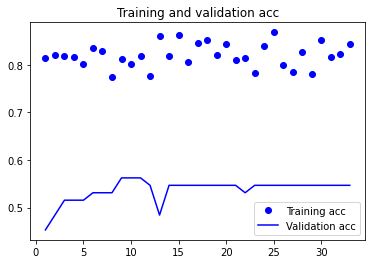

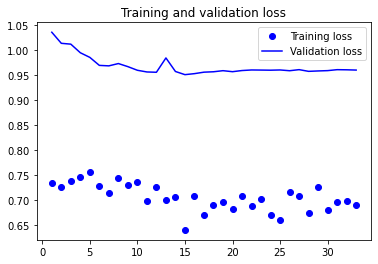

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
model = models.load_model('dental_ResNet50V2_3.h5')

In [10]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name ==  model.layers[0].layers[182].name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [11]:
len(model.trainable_weights)

11

In [12]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
dense_2

conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [13]:
callbacks_list_4 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 9,
        mode = max
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='dental_ResNet50V2_4.h5',
        monitor='val_loss',
        save_best_only=True,
        period = 1
    )
]

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras\callbacks\callbacks.py:788: RuntimeWarning: EarlyStopping mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


In [14]:
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [15]:
# Train model
history = model.fit(train_data, one_hot_train_labels,
                    epochs=20,
                    batch_size=35,
                    callbacks = callbacks_list_4,
                    validation_data=(val_data, one_hot_validation_labels))

Train on 256 samples, validate on 64 samples
Epoch 1/20
256/256 [==============================] - 27s 107ms/step - loss: 0.1427 - acc: 0.9805 - val_loss: 2.0317 - val_acc: 0.3438
Epoch 2/20
256/256 [==============================] - 13s 52ms/step - loss: 0.1231 - acc: 0.9805 - val_loss: 2.0184 - val_acc: 0.3438
Epoch 3/20
256/256 [==============================] - 13s 51ms/step - loss: 0.1244 - acc: 0.9844 - val_loss: 2.0449 - val_acc: 0.3438
Epoch 4/20
256/256 [==============================] - 13s 52ms/step - loss: 0.1272 - acc: 0.9883 - val_loss: 2.0767 - val_acc: 0.3438
Epoch 5/20
256/256 [==============================] - 13s 51ms/step - loss: 0.1261 - acc: 0.9883 - val_loss: 2.1025 - val_acc: 0.3594
Epoch 6/20
256/256 [==============================] - 13s 52ms/step - loss: 0.1214 - acc: 0.9883 - val_loss: 2.1083 - val_acc: 0.3438
Epoch 7/20
256/256 [==============================] - 13s 51ms/step - loss: 0.1101 - acc: 0.9805 - val_loss: 2.1386 - val_acc: 0.3438
Epoch 8/20
256/2

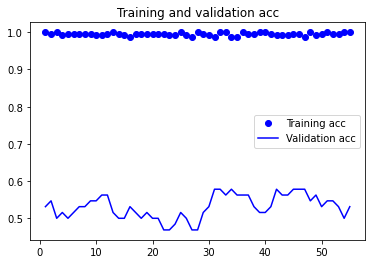

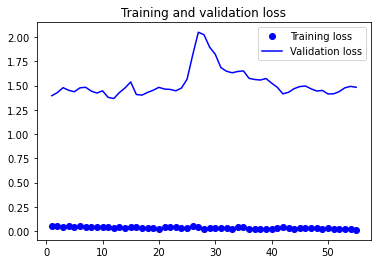

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
model = models.load_model('dental_ResNet50V2_4.h5')

In [10]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block2_1_relu':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [13]:
len(model.trainable_weights)

21

In [12]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
dense_2

conv5_block2_1_relu
conv5_block2_2_pad
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_out
conv5_block3_preact_bn
conv5_block3_preact_relu
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [14]:
callbacks_list_5 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 24,
        mode = max
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='dental_ResNet50V2_5.h5',
        monitor='val_loss',
        save_best_only=True,
        period = 1
    )
]

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras\callbacks\callbacks.py:788: RuntimeWarning: EarlyStopping mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


In [15]:
model.compile(optimizer=optimizers.Adam(1e-6),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
# Train model
history = model.fit(train_data, one_hot_train_labels,
                    epochs=150,
                    batch_size=30,
                    callbacks = callbacks_list_5,
                    validation_data=(val_data, one_hot_validation_labels))

Train on 256 samples, validate on 64 samples
Epoch 1/150
256/256 [==============================] - 25s 98ms/step - loss: 0.0352 - acc: 1.0000 - val_loss: 1.3754 - val_acc: 0.5625
Epoch 2/150
256/256 [==============================] - 14s 54ms/step - loss: 0.0393 - acc: 1.0000 - val_loss: 1.3838 - val_acc: 0.5312
Epoch 3/150
256/256 [==============================] - 14s 54ms/step - loss: 0.0330 - acc: 0.9961 - val_loss: 1.3920 - val_acc: 0.5312
Epoch 4/150
256/256 [==============================] - 14s 54ms/step - loss: 0.0424 - acc: 1.0000 - val_loss: 1.3951 - val_acc: 0.5312
Epoch 5/150
256/256 [==============================] - 14s 54ms/step - loss: 0.0442 - acc: 0.9922 - val_loss: 1.3977 - val_acc: 0.5156
Epoch 6/150
256/256 [==============================] - 14s 54ms/step - loss: 0.0346 - acc: 0.9922 - val_loss: 1.4011 - val_acc: 0.5156
Epoch 7/150
256/256 [==============================] - 14s 54ms/step - loss: 0.0320 - acc: 0.9961 - val_loss: 1.4033 - val_acc: 0.5156
Epoch 8/15

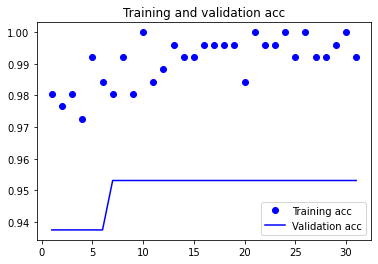

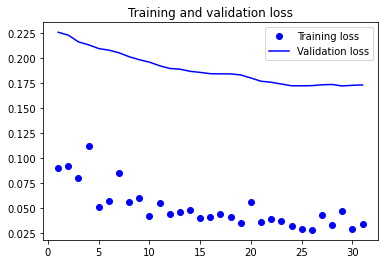

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test,
    